# Simulación (75.26-95.19) - Trabajo práctico #2

**-Integrantes del equipo:**

| Nombre           | Apellido      | Padrón |Correo electrónico
|------------------|---------------|--------|------------------
| Alexander Carlos | Villa Jimenez | 95428  | avilla@fi.uba.ar
| Víctor Manuel    | Zacarías Rojas | 107080 | vzacarias@fi.uba.ar
| Kevin Mateo      | Spasiuk       | 99849|kevin_spasiuk@hotmail.com

# Setup del entorno de trabajo 

In [1]:
pip install simpy



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import simpy as sp
import random
import random as rd
import numpy as np
import matplotlib.pyplot as plt

# Parte #1: Simulación de congestión en consultas a bases de datos

En esta sección se simuló el comportamiento de dos tipos de arquitecturas de base de datos ante congestión en 
las consultas que recibe. 

- Simulaciones:

    - Arquitectura centralizada: De implementación propia.

    - Arquitectura distribuida: Implementada por el equipo #4. El objetivo es comparar la implementación local con 
        la del grupo #4

A fines de poder realizar la simulación, se estima que el tiempo que transcurre entre cada consulta a la base de datos se puede modelar según una distribución exponencial con media de 4 segundos.


## Arquitectura  centralizada - De implementación propia

<img src="image-20241029-232903.png" width="" align="" />

**Supuestos tomados para realizar la simulación:**
- La demora de la base de datos en resolver una consulta sigue una distribución exponencial con media de 0,8 segundos.
- Se simulará el procesamiento de 100,000 solicitudes.

### Simulación

A continuación, se muestra el código de la simulación para la arquitectura centralizada. El código inical son las funciones básicas necesarias para realizar la simulación.

**NOTA: LOS TIEMPOS DE LA SIMULACIÓN SE INTERPRETAN EN SEGUNDOS**

In [3]:
LAMBDA_TIEMPO_INTERCONSULTA = 0.25
LAMBDA_TIEMPO_RESOLUCION = 1.25
NUMERO_DE_CONSULTAS = 100000


def recibir_consultas(env, cola_de_consultas, tiempos_de_arribo):
    # EL TIEMPO EMPIEZA A CORRER DESDE EL INSTANTE CERO
    instante_actual = 0
    numero_de_consulta = 1
    
    print("Conectando base de datos...")
    print("[BASE DE DATOS - BUFFER DE RECEPCIÓN] Todo listo para recibir consultas!")

    for i in range(NUMERO_DE_CONSULTAS):
        tiempo_en_llegar_consulta = rd.expovariate(lambd=LAMBDA_TIEMPO_INTERCONSULTA)
        instante_actual += tiempo_en_llegar_consulta

        yield env.timeout(tiempo_en_llegar_consulta)
        print(f"[BASE DE DATOS - BUFFER DE RECEPCIÓN] Se recibió la consulta #{numero_de_consulta} a \
        los {instante_actual} segundos de haberse iniciado el servidor.")

        yield cola_de_consultas.put(i)
        tiempos_de_arribo.append(instante_actual)

        numero_de_consulta += 1



def atender_consultas(env, cola_de_consultas, tiempos_de_resolucion, tiempos_de_arribo, tiempos_de_espera_en_cola):
    
    consultas_procesadas = 0

    while consultas_procesadas < NUMERO_DE_CONSULTAS:
        id_consulta = yield cola_de_consultas.get()
        tiempo_en_cola = env.now - tiempos_de_arribo[id_consulta]
        print(f"[BASE DE DATOS - QUERYS RESOLVER] Se va a atender la consulta #{id_consulta+1}. La consulta \
        pasó {tiempo_en_cola} segundos esperando en cola.")

        tiempos_de_espera_en_cola.append(tiempo_en_cola)
        tiempo_de_resolucion = rd.expovariate(lambd=LAMBDA_TIEMPO_RESOLUCION)

        yield env.timeout(tiempo_de_resolucion)
        print(f"[BASE DE DATOS - QUERYS RESOLVER] La consulta #{id_consulta+1} se resolvió en \
        {tiempo_de_resolucion} segundos.")

        tiempos_de_resolucion.append(tiempo_de_resolucion)
        consultas_procesadas += 1

A partir de las funciones de arriba se realiza la simulación.

In [4]:
tiempos_de_arribo = []
tiempos_de_resolucion = []
tiempos_de_espera_en_cola = []


env = sp.Environment()
cola = sp.Store(env)

env.process(recibir_consultas(env, cola, tiempos_de_arribo))
env.process(atender_consultas(env, cola, tiempos_de_resolucion, tiempos_de_arribo, tiempos_de_espera_en_cola))
env.run()

[BASE DE DATOS - BUFFER DE RECEPCIÓN] Se recibió la consulta #99668 a         los 396548.5829880267 segundos de haberse iniciado el servidor.
[BASE DE DATOS - QUERYS RESOLVER] Se va a atender la consulta #99668. La consulta         pasó 0.0 segundos esperando en cola.
[BASE DE DATOS - BUFFER DE RECEPCIÓN] Se recibió la consulta #99669 a         los 396551.6953156765 segundos de haberse iniciado el servidor.
[BASE DE DATOS - BUFFER DE RECEPCIÓN] Se recibió la consulta #99670 a         los 396554.16876032983 segundos de haberse iniciado el servidor.
[BASE DE DATOS - QUERYS RESOLVER] La consulta #99668 se resolvió en         5.609392337950993 segundos.
[BASE DE DATOS - QUERYS RESOLVER] Se va a atender la consulta #99669. La consulta         pasó 2.4970646881847642 segundos esperando en cola.
[BASE DE DATOS - QUERYS RESOLVER] La consulta #99669 se resolvió en         0.33230742963574367 segundos.
[BASE DE DATOS - QUERYS RESOLVER] Se va a atender la consulta #99670. La consulta         pasó

### Análisis de resultados

Como se puede apreciar, durante la simulación, a la base de datos centralizada le llegaron 100,000 consultas. Por otra parte, la base de datos atendió las 100,000 consultas recibidas. Esto quiere decir que efectivamente la base de datos está pudiendo recibir y atender las consultas.

In [5]:
print("Cantidad que consultas que llegaron a la base de datos: ", len(tiempos_de_arribo))
print("Cantidad de consultas resueltas por la base de datos: ", len(tiempos_de_resolucion))

Cantidad que consultas que llegaron a la base de datos:  100000
Cantidad de consultas resueltas por la base de datos:  100000


**Tiempo promedio de espera en cola**

In [6]:
print("Tiempo promedio de espera en cola: ", np.mean(tiempos_de_espera_en_cola))

Tiempo promedio de espera en cola:  0.1998691731882879


El tiempo promedio de espera en cola es de 0.19 segundos. Lo que indica que la base de datos está atendiendo las consultas eficientemente.

**Porcentaje de solicitudes atendidas sin espera**

In [7]:
print("Porcentaje de solicitudes atendidas sin espera:", (tiempos_de_espera_en_cola.count(0)*100)/NUMERO_DE_CONSULTAS)

Porcentaje de solicitudes atendidas sin espera: 79.814


Alrededor del 80% de las consultas se resolvieron apenas llegaron a la base de datos. Esta cifra le hace sentido al tiempo promedio de espera en cola, ya que, ante un alto porcentaje de solicitudes atendidas sin espera, el tiempo promedio de espera en cola debería ser chico (la congestión es menor).

**Gráficos**
Se realizaron algunos gráficos para analizar con más detalle el comportamiento de la base de datos simulada.

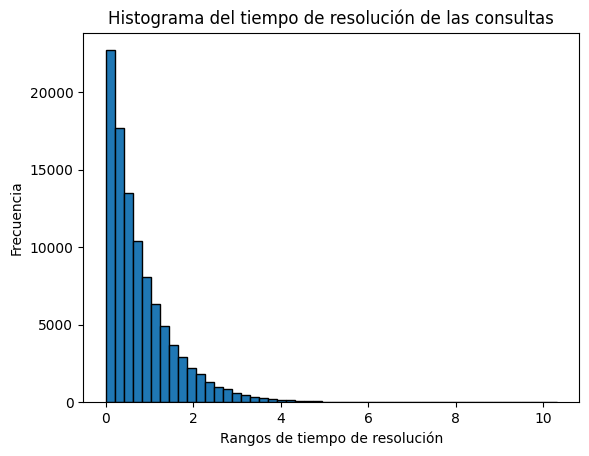

El ancho de cada barra es: 0.20614471894876996


In [8]:

bin_count, bin_edges, _ = plt.hist(tiempos_de_resolucion, bins=50, edgecolor='black')
plt.title('Histograma del tiempo de resolución de las consultas')
plt.xlabel('Rangos de tiempo de resolución')
plt.ylabel('Frecuencia')
plt.show()

ancho_barras = bin_edges[1] - bin_edges[0]
print("El ancho de cada barra es:", ancho_barras)

Como se puede apreciar el tiempo de resolución de las consultas se comporta exponencialmente. También se puede apreciar que la base de datos resuelve la gran mayoría de las consultas con rapidez (en tiempo menor a un segundo).

El ancho de cada barra es: 7800.633118502988


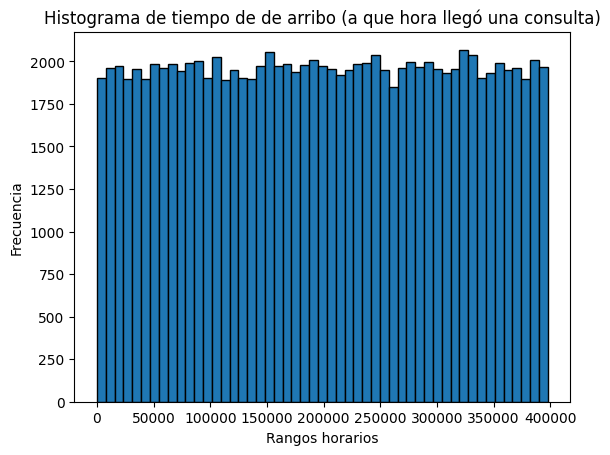

In [38]:

bin_count, bin_edges, _ = plt.hist(tiempos_de_arribo, bins=51, edgecolor='black')
plt.title('Histograma de tiempo de de arribo (a que hora llegó una consulta)')
plt.xlabel('Rangos horarios')
plt.ylabel('Frecuencia')

ancho_barras = bin_edges[1] - bin_edges[0]
print("El ancho de cada barra es:", ancho_barras)

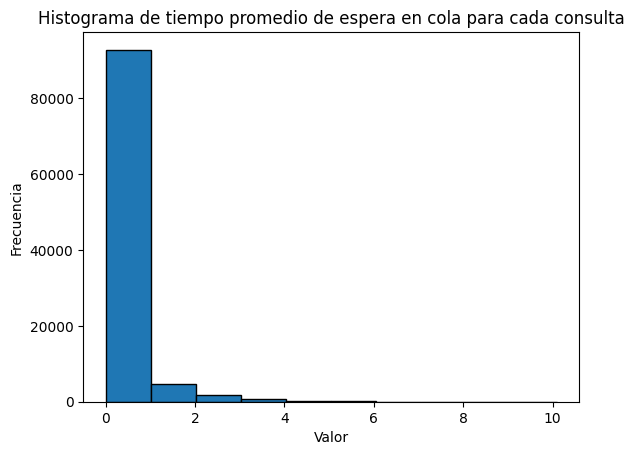

El ancho de cada barra es: 1.0091798395238585


In [41]:
bin_count, bin_edges, _ = plt.hist(tiempos_de_espera_en_cola, bins=10, edgecolor='black')
plt.title('Histograma de tiempo promedio de espera en cola para cada consulta')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

ancho_barras = bin_edges[1] - bin_edges[0]
print("El ancho de cada barra es:", ancho_barras)

El ancho de cada barra es de 0.8 segundos. La gran mayoría de la consultas caen dentro de este intervalo. EL 80% se atiende sin esperar en cola (tomando como referencia la sección anterior), mientras que el 20% es atendido con espera en cola en un tiempo muy chico.

## Arquitectura distribuida - Grupo  #4

<img src="image-20241029-233606.png" width="" align="" />

**Supuestos tomados para realizar la simulación:**
- Con probabilidad P = 0.7 las solicitudes son atendidas por la base de datos #1 y con probabilidad Q = 0.3 las solicitudes son atendidos por la base de datos #2.
- El tiempo que demora cada base de datos en atender una solicitud sigue una distribución exponencial con medias, μ1=0,7 segundos y μ2=1 segundos respectivamente.
- Se simulará el procesamiento de 100,000 solicitudes.

### Simulación

In [13]:
class BaseDeDatos(sp.Resource):

  def __init__(self, env, mu_demora, probabilidad = 1):
    super().__init__(env, 1)

    self.mu_demora = mu_demora
    self.probabilidad = probabilidad # Probabilidad de atender solicitud

  def get_demora_solicitud(self):
    return random.expovariate(1 / self.mu_demora)

class Solicitud():

  def __init__(self, env):
    self.env = env

  def procesar(self, bdd, estadisticas):
    tiempo_llegada = self.env.now

    with bdd.request() as req:
      yield req

      tiempo_inicio_proceso = self.env.now
      tiempo_de_espera = tiempo_inicio_proceso - tiempo_llegada
      estadisticas.agregar_tiempo_de_espera(tiempo_de_espera)

      demora = bdd.get_demora_solicitud()
      yield self.env.timeout(demora)

class Estadisticas():

    def __init__(self):
      self.espera_acumulada = 0
      self.solicitudes_atendidas_sin_espera = 0
      self.numero_solicitud = 0
      self.historial_tiempos_espera = []
      self.historial_solicitudes = []

    def agregar_tiempo_de_espera(self, tiempo_de_espera):
      self.numero_solicitud += 1
      if tiempo_de_espera == 0:
        self.solicitudes_atendidas_sin_espera += 1

      self.espera_acumulada += tiempo_de_espera
      self.historial_tiempos_espera.append(tiempo_de_espera)
      self.historial_solicitudes.append(self.numero_solicitud)

    def tiempo_medio_de_espera(self):
      return self.espera_acumulada / cantidad_solicitudes

    def proporcion_solicitudes_sin_espera(self):
      return self.solicitudes_atendidas_sin_espera / cantidad_solicitudes

def generar_solicitudes(env, cantidad_solicitudes, intervalo_llegadas, bases_de_datos, estadisticas):
    for _ in range(cantidad_solicitudes):
        bdd = seleccionar_base_de_datos(bases_de_datos)

        solicitud = Solicitud(env)
        env.process(solicitud.procesar(bdd, estadisticas))

        t = random.expovariate(1.0 / intervalo_llegadas)
        yield env.timeout(t)

def seleccionar_base_de_datos(bases_de_datos):
  return np.random.choice(bases_de_datos, p = [bdd.probabilidad for bdd in bases_de_datos])

def simular_dos_bases(mu_demora_1, mu_demora_2):
  env = sp.Environment()

  estadisticas = Estadisticas()    
  bases_de_datos = [BaseDeDatos(env, mu_demora_1, 0.7), BaseDeDatos(env, mu_demora_2, 0.3)]
  env.process(generar_solicitudes(env, cantidad_solicitudes, intervalo_llegadas, bases_de_datos, estadisticas))
  env.run()
  return estadisticas

cantidad_solicitudes = 100_000
intervalo_llegadas = 4

mu_demora_1 = 0.7
mu_demora_2 = 1
estadisticas = simular_dos_bases(mu_demora_1, mu_demora_2)


A partir de la estadísticas obtengo métricas de la simulación.

In [14]:
tiempos_de_espera_bdd_dist = estadisticas.historial_tiempos_espera


### Análisis de resultados

In [15]:
print('Tiempo medio de espera: %f' % estadisticas.tiempo_medio_de_espera())
print('Proporicion de solicitudes atendidas sin espera: %f' % estadisticas.proporcion_solicitudes_sin_espera())

Tiempo medio de espera: 0.094258
Proporicion de solicitudes atendidas sin espera: 0.891830



| BASE DE DATOS | TIEMPO MEDIO DE ESPERA EN COLA | PORCENTAJE DE SOLICITUDES ATENIDAS SIN ESPERA 
|---------------|--------------------------------|------------------
| Centralizada  | 0.190 segundos                 | 80%
| Distribuida   | 0.090 segundos                 | 89%


La arquitectura simulada por el grupo #4 (distriubida) eviencia un comportamiento ligeramente más eficiente respecto a nuestra arquitectura centralizada. Lógicamente, al tener una arquitecturad distribuida la base de datos tiene un mejor comportamiento ante la congestión.

**Gráficos**

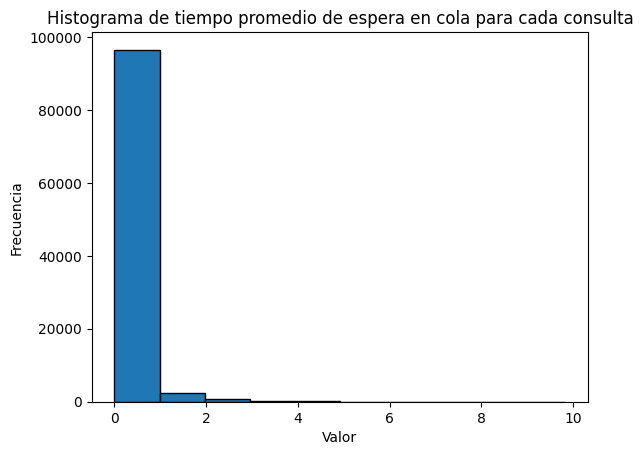

El ancho de cada barra es: 0.9828936422098196


In [43]:
bin_count, bin_edges, _ = plt.hist(tiempos_de_espera_bdd_dist, bins=10, edgecolor='black')
plt.title('Histograma de tiempo promedio de espera en cola para cada consulta')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

ancho_barras = bin_edges[1] - bin_edges[0]
print("El ancho de cada barra es:", ancho_barras)

No se observan diferencias relevantes en el histograma del tiempo promedio de espera en cola respecto a la base de datos centralizada. El comportamiento es el esperado, el tiempo promedio de espera en cola es chico y un alto porcentaje de las consultas son atendidas sin espera.

# Parte #2: Simulación de balanceador de carga

<img src="image-20241029-234546.png" width="" align="" />

### Introduccion

Un balanceador de carga es un componente de red o software cuya función principal es distribuir el tráfico o las solicitudes de los usuarios entre varios servidores o recursos de manera que ninguno de los servidores quede sobrecargado. 
Su objetivo es optimizar la utilización de los recursos, mejorar la fiabilidad del sistema y garantizar un rendimiento más eficiente de las aplicaciones o servicios que se están proporcionando.

### Objetivo del ejercicio

Realizar varias simulaciones basadas en la política de balanceo de servidor fijo y con la política de balanceo difusivo(propuesta en el paper). Al mismo tiempo ir variando entre distintos ambientes y parametros como el numero de servidores, la tasa de llegada de requerimientos, el tiempo de procesamiento, etc. Para poder evaluar estos resultados en funcion de metricas como el desvio, la media, mediana, la distribuciones de tiempo, etc.

## Implementación de clases para la simulación

A continuación presentamos el diagrama de clases:

<img src="Untitled diagram-2024-11-10-114945.png" width="" align="" />

Mostramos a continuación un diagrama de secuencias donde se expone a alto nivel el algoritmo desarrollado.

<img src="Secuencia tp2 simulacion-2024-11-10-182849.png" width="" align="" />

In [17]:
#CREACION DE POLITICAS DE BALANCEO
class RoundRobin:
    def __init__(self):
        self.indice_actual = 0
    
    def obtener_servidor(self, servidores, cliente):
        servidor = servidores[self.indice_actual]
        self.indice_actual = (self.indice_actual + 1) % len(servidores)
        return servidor

class ServerFijo:
    def obtener_servidor(self, servidores, cliente):
        return servidores[cliente.id % len(servidores)]

In [18]:
#BALANCEADOR BASE
class Balanceador:    
    def __init__(self, env, politica_balanceo, configuracion):
        self.env = env
        self.MAX_SERVER = configuracion["max_servidores"]
        self.crear_servidores(env, configuracion)
        self.politica = politica_balanceo
        
    def crear_servidores(self, env, configuracion):
        self.servidores = []
        for i in range(self.MAX_SERVER):                
            self.servidores.append(Servidor(env,i, configuracion))            
    
    def balancear(self, cliente):
        return self.politica.obtener_servidor(self.servidores, cliente)

# SERVIDOR BASE
class Servidor:
     
    def __init__(self, env, id, configuracion):
        self.env = env
        self.id = id
        self.CAPACIDAD_CLI = configuracion["capacidad_servidor"]
        self.configuracion = configuracion
        self.recurso_clientes = sp.Resource(env,capacity=self.CAPACIDAD_CLI)
        
    def peticion_servidor_crear_objeto(self, cliente):
        yield self.env.timeout(0)
        return self

    def crear_objeto(self, cliente, duracion):
        cli = self.recurso_clientes.request()
        yield cli
        yield self.env.timeout(duracion)
        self.recurso_clientes.release(cli)
        
    def operar_objeto(self, cliente, duracion):
         cli = self.recurso_clientes.request()
         yield cli
         yield self.env.timeout(duracion)
         self.recurso_clientes.release(cli)

    def destruir_objeto(self, cliente, duracion):
         cli = self.recurso_clientes.request()
         yield cli
         yield self.env.timeout(duracion)
         self.recurso_clientes.release(cli)        

In [19]:
#LOGICA DE CLIENTE

class Cliente:
    AVG_WAIT = 5
    AVG_CREATE = 10
    AVG_METHOD = 10
    AVG_DESTROY = 10
    
    def __init__(self, env, id, balanceador, configuracion):
        self.env = env
        self.id = id
        self.balanceador = balanceador
        self.tiempo_inicio = env.now
        self.tiempo_esperado = 0
        self.tiempo_total = 0
        self.configuracion = configuracion
        self.servidor_asignado = None 
        
    def wait(self, duracion):
        yield self.env.timeout(duracion)

    def procesar(self):
        cant_objetos = random_number(self.configuracion["objetos_por_cliente"], self.configuracion["desvios_objetos_por_cliente"])
        total_operaciones = 0

        for j in range(cant_objetos):
            # Balancea solo al inicio de la creación del objeto
            servidor = self.balanceador.balancear(self)
            espera_wait = random_number(self.configuracion["delay_entre_objetos"])
            espera_create = random_number(self.AVG_CREATE)

            # Espera antes de crear el objeto
            yield self.env.process(self.wait(espera_wait))

            servidor_asignado = yield self.env.process(servidor.peticion_servidor_crear_objeto(self))

            yield env.timeout(1)
            self.servidor_asignado = servidor_asignado
            
            # Crear el objeto en el servidor asignado
            yield self.env.process(self.servidor_asignado.crear_objeto(self, espera_create))
            self.tiempo_esperado += espera_wait + espera_create
            
            cant_operaciones = random_number(self.configuracion["operaciones_por_objeto"], self.configuracion["desvios_operaciones_por_objeto"])
            total_operaciones += cant_operaciones
            
            for i in range(cant_operaciones):
                espera_wait = random_number(self.configuracion["delay_entre_operaciones"])
                espera_method = random_number(self.AVG_METHOD)
                
                # Operar objeto y esperar entre operaciones
                yield self.env.process(self.servidor_asignado.operar_objeto(self, espera_method))
                yield self.env.process(self.wait(espera_wait))
                self.tiempo_esperado += espera_wait + espera_method
                
            # Destruir el objeto en el servidor asignado
            espera_destroy = random_number(self.AVG_DESTROY)
            yield self.env.process(self.servidor_asignado.destruir_objeto(self, espera_destroy))
            self.tiempo_esperado += espera_destroy 

        # Calcular tiempo total al finalizar todas las operaciones de este cliente
        self.tiempo_total = self.env.now - self.tiempo_inicio
        if self.configuracion["stats"]:
            print('[STAT] CLI: %d. TOTAL_OB: %d, TOTAL_OP: %d, T_INI: %d, EXPECTED: %d, REAL: %d' % 
                (self.id, cant_objetos, total_operaciones, self.tiempo_inicio, self.tiempo_esperado, self.tiempo_total))
        
def random_number(avg, desvio = 0.5):
    return abs(round(rd.normalvariate(mu=avg, sigma=desvio)))

In [20]:
class BalanceadorDiffusive(Balanceador):
    def __init__(self, env, politica_balanceo, configuracion):
        self.env = env
        self.MAX_SERVER = len(configuracion["matriz_adyacencia"])
        self.crear_servidores(env, configuracion["matriz_adyacencia"], configuracion)
        self.politica = politica_balanceo

    def crear_servidores(self, env, matriz_adyacencia, configuracion):
        self.servidores = []
        for i in range(self.MAX_SERVER):                
            self.servidores.append(ServidorDiffusive(env,i, configuracion))
            
        for i in range(self.MAX_SERVER):
            for j, conexion in enumerate(matriz_adyacencia[i]):
                if conexion == 1:
                    self.servidores[i].agregar_vecino(self.servidores[j])

class ServidorDiffusive(Servidor):
    
    def __init__(self, env, id, configuracion):
        self.vecinos = []
        self.carga = 0
        self.UMBRAL = configuracion["umbral_carga"]
        self.ultimo_acceso = {}
        super().__init__(env, id, configuracion)
        
 
    def agregar_vecino(self,servidor):
        self.vecinos.append(servidor)

    def registrar_acceso(self, cliente):
        self.ultimo_acceso[cliente.id] = self.env.now

    def peticion_servidor_crear_objeto(self, cliente):
        vecino_menos_cargado = min(self.vecinos, key=lambda vecino: vecino.carga)
        
        #if self.configuracion["stats"]: 
        #    print(f"Sever:{self.id}: {self.carga} | Vecino {vecino_menos_cargado.id}: {vecino_menos_cargado.carga}")
        
        if self.carga - vecino_menos_cargado.carga > self.UMBRAL:
            if self.configuracion["stats"]:    
                print(f"Cambio de server {vecino_menos_cargado.id}, cliente: {cliente.id}. T= {self.env.now}")
            yield self.env.timeout(configuracion["delay_entre_servidores"])
            return vecino_menos_cargado  
        else:
            return self 
        
    def crear_objeto(self, cliente, duracion):    
        self.registrar_acceso(cliente)
        self.carga += 1
        #print(f"carga: {self.carga}, ultimo acceso: {cliente.id}, {self.ultimo_acceso[cliente.id]}")
        #print('Server: %d, cliente: %d. START crear a los %d min' % (self.id, cliente.id, env.now))
        cli = self.recurso_clientes.request()
        yield cli 
        yield self.env.timeout(duracion)
        self.recurso_clientes.release(cli)
        
    def operar_objeto(self, cliente, duracion):
         #print('Server: %d, cliente: %d. START crear a los %d min' % (self.id, cliente.id, env.now))
         self.registrar_acceso(cliente)
         cli = self.recurso_clientes.request()
         yield cli 
         yield self.env.timeout(duracion)
         self.recurso_clientes.release(cli)

    def destruir_objeto(self, cliente, duracion):
        self.registrar_acceso(cliente)
        cli = self.recurso_clientes.request()
        yield cli 
        yield self.env.timeout(duracion)
        self.recurso_clientes.release(cli)
        self.carga -= 1

In [21]:
def simular(env, balanceador, configuracion):
    clientes = []
    for i in range(configuracion["max_clientes"]):
        cli = Cliente(env, i, balanceador, configuracion)
        env.process(cli.procesar())
        clientes.append(cli)
        
        tiempo_entre_llegadas = rd.expovariate(configuracion["tasa_llegada"])
        if configuracion["stats"]:
            print(f"T: {env.now}, Arribo Cliente: {cli.id}, Tiempo de espera entre llegadas: {tiempo_entre_llegadas:.2f}")
        
        yield env.timeout(tiempo_entre_llegadas)
        
    return clientes

## Simulación 

Las simulaciones se realizan con la política de balanceo de servidor fijo y con la política de balanceo difusivo.
Los ambientes a analizar (y algunas de sus configuraciones) van a ser los siguientes:
- Simulacion de baja escala:
  - Cantidad de clientes = 20
  - Cantidad de servidores = 5
- Simulacion en Intranet:
  - Cantidad de clientes = 55
  - Cantidad de servidores = 5
- Simulacion en Internet:
  - Cantidad de clientes = 120
  - Cantidad de servidores = 5

Luego se analizará situaciones con 3 y 8 servidores para realizar comparativas.

Observación: Al usar variables aleatorias los resultados varian ejecución a ejecución.

### Simulación de baja escala

Simulación con política de servidor fijo

In [22]:
#Simulacion Server Fijo

configuracion = {
    "tasa_llegada": 3,             
    "max_clientes": 20,
    "max_servidores": 5,          
    "capacidad_servidor": 5,
    "objetos_por_cliente": 1,
    "desvios_objetos_por_cliente": 0,
    "operaciones_por_objeto": 15,
    "desvios_operaciones_por_objeto": 1,
    "delay_entre_objetos": 100,
    "delay_entre_operaciones": 2000,
    "matriz_adyacencia": [], #config para difusivo
    "umbral_carga": 2, #config para difusivo
    "delay_entre_servidores": 1, #config para difusivo
    "stats": True                 
}

env = sp.Environment()
politica = ServerFijo()
balanceador = Balanceador(env, politica, configuracion)

clientes = env.process(simular(env, balanceador,configuracion))
env.run()

# Calcular y mostrar métricas después de que todos los clientes hayan terminado
tiempo_total_espera = sum(cliente.tiempo_total for cliente in clientes.value)
tiempo_transcurrido = env.now
print("Tiempo transcurrido =", tiempo_transcurrido)
print("Tiempo de espera total de los clientes =", tiempo_total_espera)

T: 0, Arribo Cliente: 0, Tiempo de espera entre llegadas: 0.09
T: 0.08584017942559254, Arribo Cliente: 1, Tiempo de espera entre llegadas: 0.11
T: 0.19428375283714133, Arribo Cliente: 2, Tiempo de espera entre llegadas: 0.28
T: 0.47162007952466767, Arribo Cliente: 3, Tiempo de espera entre llegadas: 0.01
T: 0.4808655346279312, Arribo Cliente: 4, Tiempo de espera entre llegadas: 0.82
T: 1.3034507370548443, Arribo Cliente: 5, Tiempo de espera entre llegadas: 0.07
T: 1.3763802161478433, Arribo Cliente: 6, Tiempo de espera entre llegadas: 0.37
T: 1.7431227208491942, Arribo Cliente: 7, Tiempo de espera entre llegadas: 0.06
T: 1.80224412426589, Arribo Cliente: 8, Tiempo de espera entre llegadas: 0.22
T: 2.0212353561791643, Arribo Cliente: 9, Tiempo de espera entre llegadas: 0.38
T: 2.4051544427850917, Arribo Cliente: 10, Tiempo de espera entre llegadas: 0.00
T: 2.40946311339143, Arribo Cliente: 11, Tiempo de espera entre llegadas: 0.02
T: 2.4307505309828223, Arribo Cliente: 12, Tiempo de esp

Simulación con política de balanceo difusivo:

In [23]:
#SIMULACION DIFUSIVA

matriz_adyacencia_5 = [
    [0, 1, 1, 0, 0],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 1, 1],
    [1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0],
]


In [24]:
configuracion = {
    "tasa_llegada": 3,             
    "max_clientes": 20,
    "max_servidores": 5,          
    "capacidad_servidor": 5,
    "objetos_por_cliente": 1,
    "desvios_objetos_por_cliente": 0,
    "operaciones_por_objeto": 15,
    "desvios_operaciones_por_objeto": 1,
    "delay_entre_objetos": 100,
    "delay_entre_operaciones": 2000,
    "matriz_adyacencia": matriz_adyacencia_5, #config para difusivo
    "umbral_carga": 1, #config para difusivo
    "delay_entre_servidores": 2, #config para difusivo
    "stats": True                 
}

env = sp.Environment()
politica = RoundRobin()
balanceador = BalanceadorDiffusive(env, politica, configuracion)

clientes = env.process(simular(env, balanceador,configuracion))
env.run()

tiempo_total_espera = sum(cliente.tiempo_total for cliente in clientes.value)
tiempo_transcurrido = env.now
print("Tiempo transcurrido =", tiempo_transcurrido)
print("Tiempo de espera total de los clientes =", tiempo_total_espera)

T: 0, Arribo Cliente: 0, Tiempo de espera entre llegadas: 0.18
T: 0.17614854608235556, Arribo Cliente: 1, Tiempo de espera entre llegadas: 0.12
T: 0.29448212544468544, Arribo Cliente: 2, Tiempo de espera entre llegadas: 0.53
T: 0.8195854680562572, Arribo Cliente: 3, Tiempo de espera entre llegadas: 0.07
T: 0.8868285354135085, Arribo Cliente: 4, Tiempo de espera entre llegadas: 0.48
T: 1.3711165887514956, Arribo Cliente: 5, Tiempo de espera entre llegadas: 0.05
T: 1.4195210707396673, Arribo Cliente: 6, Tiempo de espera entre llegadas: 1.73
T: 3.1504281431123227, Arribo Cliente: 7, Tiempo de espera entre llegadas: 0.37
T: 3.5179600934561517, Arribo Cliente: 8, Tiempo de espera entre llegadas: 0.03
T: 3.5449062043000823, Arribo Cliente: 9, Tiempo de espera entre llegadas: 0.16
T: 3.7090709157278403, Arribo Cliente: 10, Tiempo de espera entre llegadas: 0.41
T: 4.116192958351932, Arribo Cliente: 11, Tiempo de espera entre llegadas: 0.09
T: 4.205281362631727, Arribo Cliente: 12, Tiempo de es

Resultados ambiente local:

**Servidor fijo:**
Tiempo transcurrido = 34287.00325034813
Tiempo de espera total de los clientes = 601378.0

**Balanceo Difusivo:**
Tiempo transcurrido = 34301.4614596407
Tiempo de espera total de los clientes = 603452.0

### Simulación Intranet

In [25]:
#Simulacion Server Fijo

configuracion = {
    "tasa_llegada": 5,             
    "max_clientes": 55,
    "max_servidores": 5,          
    "capacidad_servidor": 5,
    "objetos_por_cliente": 5,
    "desvios_objetos_por_cliente": 2,
    "operaciones_por_objeto": 5,
    "desvios_operaciones_por_objeto": 1,
    "delay_entre_objetos": 100,
    "delay_entre_operaciones": 2000,
    "matriz_adyacencia": [], #config para difusivo
    "umbral_carga": 0, #config para difusivo
    "delay_entre_servidores": 0, #config para difusivo
    "stats": False                 
}

env = sp.Environment()
politica = ServerFijo()
balanceador = Balanceador(env, politica, configuracion)

clientes = env.process(simular(env, balanceador,configuracion))
env.run()

# Calcular y mostrar métricas después de que todos los clientes hayan terminado
tiempo_total_espera = sum(cliente.tiempo_total for cliente in clientes.value)
tiempo_transcurrido = env.now
print("Tiempo transcurrido =", tiempo_transcurrido)
print("Tiempo de espera total de los clientes =", tiempo_total_espera)

Tiempo transcurrido = 85412.94176431559
Tiempo de espera total de los clientes = 2848681.5010472117


In [26]:
configuracion = {
    "tasa_llegada": 5,             
    "max_clientes": 55,
    "max_servidores": 5,          
    "capacidad_servidor": 5,
    "objetos_por_cliente": 5,
    "desvios_objetos_por_cliente": 2,
    "operaciones_por_objeto": 5,
    "desvios_operaciones_por_objeto": 1,
    "delay_entre_objetos": 100,
    "delay_entre_operaciones": 2000,
    "matriz_adyacencia": matriz_adyacencia_5, #config para difusivo
    "umbral_carga": 2, #config para difusivo
    "delay_entre_servidores": 2, #config para difusivo
    "stats": False                 
}

env = sp.Environment()
politica = RoundRobin()
balanceador = BalanceadorDiffusive(env, politica, configuracion)

clientes = env.process(simular(env, balanceador,configuracion))
env.run()

tiempo_total_espera = sum(cliente.tiempo_total for cliente in clientes.value)
tiempo_transcurrido = env.now
print("Tiempo transcurrido =", tiempo_transcurrido)
print("Tiempo de espera total de los clientes =", tiempo_total_espera)

Tiempo transcurrido = 93454.78480241793
Tiempo de espera total de los clientes = 2584030.4585136394


Resultados Intranet:


**Servidor fijo:**
Tiempo transcurrido = 95701.07655573195
Tiempo de espera total de los clientes = 2756870.24526098

**Balanceo Difusivo:**
Tiempo transcurrido = 101580.74499318248
Tiempo de espera total de los clientes = 2624577.485675704

### Simulación Internet

In [27]:
#Simulacion Server Fijo

configuracion = {
    "tasa_llegada": 5,             
    "max_clientes": 120,
    "max_servidores": 5,          
    "capacidad_servidor": 5,
    "objetos_por_cliente": 5,
    "desvios_objetos_por_cliente": 5,
    "operaciones_por_objeto": 1,
    "desvios_operaciones_por_objeto": 10,
    "delay_entre_objetos": 100,
    "delay_entre_operaciones": 2000,
    "matriz_adyacencia": [], #config para difusivo
    "umbral_carga": 0, #config para difusivo
    "delay_entre_servidores": 0, #config para difusivo
    "stats": False                 
}

env = sp.Environment()
politica = ServerFijo()
balanceador = Balanceador(env, politica, configuracion)

clientes = env.process(simular(env, balanceador,configuracion))
env.run()

# Calcular y mostrar métricas después de que todos los clientes hayan terminado
tiempo_total_espera = sum(cliente.tiempo_total for cliente in clientes.value)
tiempo_transcurrido = env.now
print("Tiempo transcurrido =", tiempo_transcurrido)
print("Tiempo de espera total de los clientes =", tiempo_total_espera)

Tiempo transcurrido = 317699.5180267034
Tiempo de espera total de los clientes = 11595587.652975488


In [28]:
configuracion = {
        "tasa_llegada": 5,             
    "max_clientes": 120,
    "max_servidores": 5,          
    "capacidad_servidor": 5,
    "objetos_por_cliente": 5,
    "desvios_objetos_por_cliente": 5,
    "operaciones_por_objeto": 1,
    "desvios_operaciones_por_objeto": 10,
    "delay_entre_objetos": 100,
    "delay_entre_operaciones": 2000,
    "matriz_adyacencia": matriz_adyacencia_5, #config para difusivo
    "umbral_carga": 2, #config para difusivo
    "delay_entre_servidores": 2, #config para difusivo
    "stats": False                 
}

env = sp.Environment()
politica = RoundRobin()
balanceador = BalanceadorDiffusive(env, politica, configuracion)

clientes = env.process(simular(env, balanceador,configuracion))
env.run()

tiempo_total_espera = sum(cliente.tiempo_total for cliente in clientes.value)
tiempo_transcurrido = env.now
print("Tiempo transcurrido =", tiempo_transcurrido)
print("Tiempo de espera total de los clientes =", tiempo_total_espera)

Tiempo transcurrido = 351597.6307043822
Tiempo de espera total de los clientes = 11588429.489753356


Resultados Internet:

**Servidor fijo:**
Tiempo transcurrido = 374539.0456380392
Tiempo de espera total de los clientes = 12369897.91013923

**Balanceo difusivo:**
Tiempo transcurrido = 319811.79437734245
Tiempo de espera total de los clientes = 11462700.691655863

## Comparativa de los escenarios

Escenario: local
| Tipo balanceo    | Te      | Td  
|------------------|---------------|--------
| Servidor Fijo      | 34,287.0    | 601,378.0 
| Balanceo Difusivo  | 34,301.5    | 603,452.0    


Escenario: Intranet
| Tipo balanceo    | Te      | Td 
|------------------|---------------|--------
| Servidor Fijo      | 95,701.1    | 2,756,870.2
| Balanceo Difusivo  | 101,580.7   | 2,624,577.5   


Escenario: Internet
| Tipo balanceo    | Te      | Td 
|------------------|---------------|--------
| Servidor Fijo      | 374,539.0   | 12,369,897.9
| Balanceo Difusivo  | 319,811.8   | 11,462,700.7  

Si bien se ajustaron de forma distitna los parámetros, las conclusiones de los resultados son los mismos. En un ambiente reducido y local el balanceo estático, fijando el servidor da mejores resultados que el balanceo difusivo.

Pero a medida que crece la cantidad de clientes y la carga de los servidores, el balanceo difusivo reduce significativamente el tiempo total esperado .

## Cálculo de media y desvío

Se realizó la comparativa anterior con una sola ejecución, así que ahora vamos a realizar 5 simulaciones de cada escenario y calcularemos el la media y el desvío.

### Baja escala (local)

In [29]:
# Muestras server fijo
tiempo_transcurrido_fijo = [
    34298.020186571084,
    34299.908148755734,
    32288.90869990058,
    34287.91821280976,
    34289
]

tiempo_espera_fijo = [
    607431.0,
    619503.0,
    589330.0,
    593358.0,
    607444.0
]

# Muestras Diffusive
tiempo_transcurrido_diffusive = [
    32290.809554296367,
    32287.749339875943,
    34291.10118342892,
    36301.8721728715,
    34292.21083707634
]

tiempo_espera_diffusive = [
    609453.0,
    577280.0,
    605437.0,
    617477.0,
    599391.0
]


resultados = {
    "tiempo_transcurrido_fijo": {
        "media": np.mean(tiempo_transcurrido_fijo),
        "desviacion": np.std(tiempo_transcurrido_fijo),
        "mediana": np.median(tiempo_transcurrido_fijo)
    },
    "tiempo_espera_fijo": {
        "media": np.mean(tiempo_espera_fijo),
        "desviacion": np.std(tiempo_espera_fijo),
        "mediana": np.median(tiempo_espera_fijo)
    },
    "tiempo_transcurrido_diffusive": {
        "media": np.mean(tiempo_transcurrido_diffusive),
        "desviacion": np.std(tiempo_transcurrido_diffusive),
        "mediana": np.median(tiempo_transcurrido_diffusive)
    },
    "tiempo_espera_diffusive": {
        "media": np.mean(tiempo_espera_diffusive),
        "desviacion": np.std(tiempo_espera_diffusive),
        "mediana": np.median(tiempo_espera_diffusive)
    }
}

for clave, valores in resultados.items():
    print(f"{clave.capitalize()}:")
    print(f"  Media: {valores['media']:.2f}")
    print(f"  Desviación estándar: {valores['desviacion']:.2f}")
    print(f"  Mediana: {valores['mediana']:.2f}")
    print()

Tiempo_transcurrido_fijo:
  Media: 33892.75
  Desviación estándar: 801.94
  Mediana: 34289.00

Tiempo_espera_fijo:
  Media: 603413.20
  Desviación estándar: 10869.36
  Mediana: 607431.00

Tiempo_transcurrido_diffusive:
  Media: 33892.75
  Desviación estándar: 1500.96
  Mediana: 34291.10

Tiempo_espera_diffusive:
  Media: 601807.60
  Desviación estándar: 13598.51
  Mediana: 605437.00



### Intranet

In [30]:
#Server Fijo
tiempo_transcurrido_fijo = [
    95701.07655573195,
    97584.47578958453,
    93581.59082497389,
    89533.72331054349,
    99725.3290870247
]

tiempo_espera_fijo = [
    2756870.24526098,
    2621344.6468438534,
    2847119.572898036,
    2887367.1530803866,
    3011374.2749461923
]

# Diffusive
tiempo_transcurrido_diffusive = [
    95460.10246488787,
    89674.5243358246,
    105760.5489632169,
    109756.71867415358,
    81389.24363361561
]

tiempo_espera_diffusive = [
    2909682.3223804045,
    2615123.8813133584,
    2458200.6150686317,
    2928141.141656936,
    2828196.560010418
]

resultados = {
    "tiempo_transcurrido_fijo": {
        "media": np.mean(tiempo_transcurrido_fijo),
        "desviacion": np.std(tiempo_transcurrido_fijo),
        "mediana": np.median(tiempo_transcurrido_fijo)
    },
    "tiempo_espera_fijo": {
        "media": np.mean(tiempo_espera_fijo),
        "desviacion": np.std(tiempo_espera_fijo),
        "mediana": np.median(tiempo_espera_fijo)
    },
    "tiempo_transcurrido_diffusive": {
        "media": np.mean(tiempo_transcurrido_diffusive),
        "desviacion": np.std(tiempo_transcurrido_diffusive),
        "mediana": np.median(tiempo_transcurrido_diffusive)
    },
    "tiempo_espera_diffusive": {
        "media": np.mean(tiempo_espera_diffusive),
        "desviacion": np.std(tiempo_espera_diffusive),
        "mediana": np.median(tiempo_espera_diffusive)
    }
}

for clave, valores in resultados.items():
    print(f"{clave.capitalize()}:")
    print(f"  Media: {valores['media']:.2f}")
    print(f"  Desviación estándar: {valores['desviacion']:.2f}")
    print(f"  Mediana: {valores['mediana']:.2f}")
    print()

Tiempo_transcurrido_fijo:
  Media: 95225.24
  Desviación estándar: 3496.80
  Mediana: 95701.08

Tiempo_espera_fijo:
  Media: 2824815.18
  Desviación estándar: 130561.33
  Mediana: 2847119.57

Tiempo_transcurrido_diffusive:
  Media: 96408.23
  Desviación estándar: 10367.83
  Mediana: 95460.10

Tiempo_espera_diffusive:
  Media: 2747868.90
  Desviación estándar: 182572.26
  Mediana: 2828196.56



### Internet

In [31]:
# Server Fijo
tiempo_transcurrido_fijo = [
    295590.3154483586,
    352194.2660907986,
    289570.7290205126,
    309315.7817339757,
    279584.13635075185
]

tiempo_espera_fijo = [
    12014288.761405589,
    10925532.509078054,
    12674773.205477241,
    11404064.371385254,
    10825147.212954931
]

# Diffusive
tiempo_transcurrido_diffusive = [
    299592.11665794754,
    406683.48679409217,
    339692.3884537141,
    372672.139929778,
    281267.3111316443
]

tiempo_espera_diffusive = [
    11277237.940705987,
    11671210.06375022,
    11835604.18498332,
    12113651.362942068,
    10264921.921548972
]

resultados = {
    "tiempo_transcurrido_fijo": {
        "media": np.mean(tiempo_transcurrido_fijo),
        "desviacion": np.std(tiempo_transcurrido_fijo),
        "mediana": np.median(tiempo_transcurrido_fijo)
    },
    "tiempo_espera_fijo": {
        "media": np.mean(tiempo_espera_fijo),
        "desviacion": np.std(tiempo_espera_fijo),
        "mediana": np.median(tiempo_espera_fijo)
    },
    "tiempo_transcurrido_diffusive": {
        "media": np.mean(tiempo_transcurrido_diffusive),
        "desviacion": np.std(tiempo_transcurrido_diffusive),
        "mediana": np.median(tiempo_transcurrido_diffusive)
    },
    "tiempo_espera_diffusive": {
        "media": np.mean(tiempo_espera_diffusive),
        "desviacion": np.std(tiempo_espera_diffusive),
        "mediana": np.median(tiempo_espera_diffusive)
    }
}

for clave, valores in resultados.items():
    print(f"{clave.capitalize()}:")
    print(f"  Media: {valores['media']:.2f}")
    print(f"  Desviación estándar: {valores['desviacion']:.2f}")
    print(f"  Mediana: {valores['mediana']:.2f}")
    print()

Tiempo_transcurrido_fijo:
  Media: 305251.05
  Desviación estándar: 25369.98
  Mediana: 295590.32

Tiempo_espera_fijo:
  Media: 11568761.21
  Desviación estándar: 695066.52
  Mediana: 11404064.37

Tiempo_transcurrido_diffusive:
  Media: 339981.49
  Desviación estándar: 46036.02
  Mediana: 339692.39

Tiempo_espera_diffusive:
  Media: 11432525.09
  Desviación estándar: 643550.70
  Mediana: 11671210.06



### Conclusión resultados

Media
| Política | Local Te | Local Td | Intranet Te | Intranet Td | Internet Te | Internet Td |
|----------|----------|----------|-------------|-------------|-------------|-------------|
| Estático | 33,892   | 603,413  | 95,225      | 2,824,815   | 305,251     | 11,568,761  |
| Difusivo | 33,892   | 601,807  | 96,408      | 2,747,868   | 339,981     | 11,432,525  |

Desvío 
| Política | Local Te | Local Td | Intranet Te | Intranet Td | Internet Te | Internet Td |
|----------|----------|----------|-------------|-------------|-------------|-------------|
| Estático | 801      | 10,869   | 3,496       | 130,561     | 25,369      | 695,066     |
| Difusivo | 1,500    | 13,598   | 10,367      | 182,572     | 46,036      | 643,550     |

Mediana
| Política | Local Te | Local Td | Intranet Te | Intranet Td | Internet Te | Internet Td |
|----------|----------|----------|-------------|-------------|-------------|-------------|
| Estático | 34,289   | 607,431  | 95,701      | 2,847,119   | 295,590     | 11,404,064  |
| Difusivo | 34,291   | 605,437  | 95,460      | 2,828,196   | 339,692     | 11,671,210  |


Vemos que la Media del tiempo total esperado de los clientes siempre es menor con la política difusiva, pero el desvío es superior que la pol´tica de servidor fijo en los ambientes locales y de intranet. Es en el escenario de Internet donde el desvío de la política difusiva es menor que la política del servidor fijo.

## Simulación con 3 servidores

Para la simulación de 3 servidores, creemos que es representativo usar el escenario de intranet ya que se ajusta mejor a la cantidad de clientes de dicho escenario.

In [32]:
matriz_adyacencia_3 = [
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0],
]

In [33]:
#Simulacion Server Fijo

configuracion = {
    "tasa_llegada": 5,             
    "max_clientes": 55,
    "max_servidores": 3,          
    "capacidad_servidor": 5,
    "objetos_por_cliente": 5,
    "desvios_objetos_por_cliente": 2,
    "operaciones_por_objeto": 5,
    "desvios_operaciones_por_objeto": 1,
    "delay_entre_objetos": 100,
    "delay_entre_operaciones": 2000,
    "matriz_adyacencia": [], #config para difusivo
    "umbral_carga": 0, #config para difusivo
    "delay_entre_servidores": 0, #config para difusivo
    "stats": False                 
}

env = sp.Environment()
politica = ServerFijo()
balanceador = Balanceador(env, politica, configuracion)

clientes = env.process(simular(env, balanceador,configuracion))
env.run()

# Calcular y mostrar métricas después de que todos los clientes hayan terminado
tiempo_total_espera = sum(cliente.tiempo_total for cliente in clientes.value)
tiempo_transcurrido = env.now
print("Tiempo transcurrido =", tiempo_transcurrido)
print("Tiempo de espera total de los clientes =", tiempo_total_espera)

Tiempo transcurrido = 105883.40834184928
Tiempo de espera total de los clientes = 2797472.4425510294


In [34]:
configuracion = {
    "tasa_llegada": 5,             
    "max_clientes": 55,
    "max_servidores": 3,          
    "capacidad_servidor": 5,
    "objetos_por_cliente": 5,
    "desvios_objetos_por_cliente": 2,
    "operaciones_por_objeto": 5,
    "desvios_operaciones_por_objeto": 1,
    "delay_entre_objetos": 100,
    "delay_entre_operaciones": 2000,
    "matriz_adyacencia": matriz_adyacencia_3, #config para difusivo
    "umbral_carga": 2, #config para difusivo
    "delay_entre_servidores": 2, #config para difusivo
    "stats": False                 
}

env = sp.Environment()
politica = RoundRobin()
balanceador = BalanceadorDiffusive(env, politica, configuracion)

clientes = env.process(simular(env, balanceador,configuracion))
env.run()

tiempo_total_espera = sum(cliente.tiempo_total for cliente in clientes.value)
tiempo_transcurrido = env.now
print("Tiempo transcurrido =", tiempo_transcurrido)
print("Tiempo de espera total de los clientes =", tiempo_total_espera)

Tiempo transcurrido = 121961.10809227434
Tiempo de espera total de los clientes = 2794762.7337816753


Resultados Intranet:

Escenario: Intranet con 5 servidores

| Tipo balanceo    | Te      | Td 
|------------------|---------------|--------
| Servidor Fijo      | 95,701.1    | 2,756,870.2
| Balanceo Difusivo  | 101,580.7   | 2,624,577.5   

Escenario: Intranet con 3 servidores

| Tipo balanceo    | Te      | Td 
|------------------|---------------|--------
| Servidor Fijo      | 121,970.7  | 2,943,192.0
| Balanceo Difusivo  | 85,418.2   | 2,763,961.4   

Servidor fijo:
Tiempo transcurrido = 121970.79437261051
Tiempo de espera total de los clientes = 2943192.0669641607

Balanceo difusivo:
Tiempo transcurrido = 85418.24449220671
Tiempo de espera total de los clientes = 2763961.4310439085

Si bien el tiempo total esperado por los clientes es mayor ya que se cuenta con menores recursos, vemos que sigue la misma tendencia que el escenario con 5 servidores.

Para el tiempo total transcurrido creemos que laa diferencia en el escenario de servidor difusivo se debe a la topología de los servidores ya que es un grafo completo.

## Simulación con 8 servidores

Para el escenario de 8 servidores vamos a usar el contexto de Internet ya que consdieramos que aplica mejor.

In [35]:
matriz_adyacencia_8 = [
    [0, 1, 1, 0, 1, 0, 0, 1],
    [1, 0, 0, 1, 0, 1, 1, 0],
    [1, 0, 0, 1, 1, 0, 1, 1],
    [0, 1, 1, 0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0, 0, 1, 1],
    [0, 1, 0, 1, 0, 0, 1, 1],
    [0, 1, 1, 0, 1, 1, 0, 1],
    [1, 0, 1, 0, 1, 1, 1, 0]
]

In [36]:
#Simulacion Server Fijo

configuracion = {
    "tasa_llegada": 5,             
    "max_clientes": 120,
    "max_servidores": 8,          
    "capacidad_servidor": 5,
    "objetos_por_cliente": 5,
    "desvios_objetos_por_cliente": 5,
    "operaciones_por_objeto": 1,
    "desvios_operaciones_por_objeto": 10,
    "delay_entre_objetos": 100,
    "delay_entre_operaciones": 2000,
    "matriz_adyacencia": [], #config para difusivo
    "umbral_carga": 0, #config para difusivo
    "delay_entre_servidores": 0, #config para difusivo
    "stats": False                 
}

env = sp.Environment()
politica = ServerFijo()
balanceador = Balanceador(env, politica, configuracion)

clientes = env.process(simular(env, balanceador,configuracion))
env.run()

# Calcular y mostrar métricas después de que todos los clientes hayan terminado
tiempo_total_espera = sum(cliente.tiempo_total for cliente in clientes.value)
tiempo_transcurrido = env.now
print("Tiempo transcurrido =", tiempo_transcurrido)
print("Tiempo de espera total de los clientes =", tiempo_total_espera)


Tiempo transcurrido = 333392.79538595106
Tiempo de espera total de los clientes = 11694498.440136462


In [37]:
configuracion = {
    "tasa_llegada": 5,             
    "max_clientes": 120,
    "max_servidores": 8,          
    "capacidad_servidor": 5,
    "objetos_por_cliente": 5,
    "desvios_objetos_por_cliente": 5,
    "operaciones_por_objeto": 1,
    "desvios_operaciones_por_objeto": 10,
    "delay_entre_objetos": 100,
    "delay_entre_operaciones": 2000,
    "matriz_adyacencia": matriz_adyacencia_8, #config para difusivo
    "umbral_carga": 2, #config para difusivo
    "delay_entre_servidores": 2, #config para difusivo
    "stats": False                 
}

env = sp.Environment()
politica = RoundRobin()
balanceador = BalanceadorDiffusive(env, politica, configuracion)

clientes = env.process(simular(env, balanceador,configuracion))
env.run()

tiempo_total_espera = sum(cliente.tiempo_total for cliente in clientes.value)
tiempo_transcurrido = env.now
print("Tiempo transcurrido =", tiempo_transcurrido)
print("Tiempo de espera total de los clientes =", tiempo_total_espera)

Tiempo transcurrido = 268715.2549897671
Tiempo de espera total de los clientes = 10109393.681038365


Escenario: Internet 5 servidores
| Tipo balanceo    | Te      | Td 
|------------------|---------------|--------
| Servidor Fijo      | 374,539.0   | 12,369,897.9
| Balanceo Difusivo  | 319,811.8   | 11,462,700.7  

Escenario: Internet 8 servidores
| Tipo balanceo    | Te      | Td 
|------------------|---------------|--------
| Servidor Fijo      | 303,076.0   | 11,724,095.4
| Balanceo Difusivo  | 346,269.4  | 11,416,656.7

Tiempo transcurrido = 303076.0966729079
Tiempo de espera total de los clientes = 11724095.497090846

Tiempo transcurrido = 346269.4686763737
Tiempo de espera total de los clientes = 11416656.74061657

Si bien el tiempo total esperado por los clientes es menor ya que se cuenta con mayores recursos, sigue la misma tendencia que el escenario con 5 servidores.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d3890b2b-2dd7-4bbe-a3ff-1a60ff7ea90b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>